Ceci ne fonctionne pas correctment mais j'aime bien le code, il faudrait descendre pour voir ce qui fonctionne 
Par fonctionner je veux dire ne donne pas un très bon score sur le tetst set

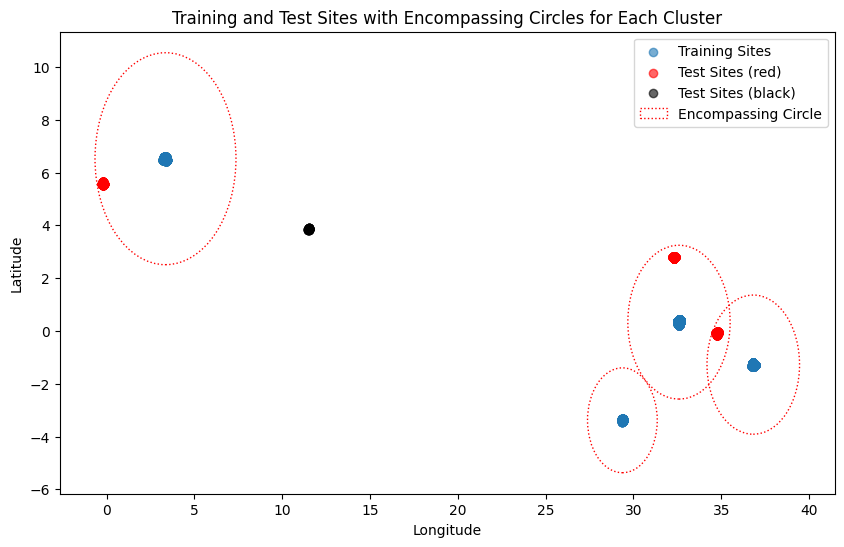

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
import matplotlib.pyplot as plt

# Load the data
train_data = pd.read_csv('Train.csv')
test_data = pd.read_csv('Test.csv')

# Extract latitude and longitude for clustering
site_coordinates = train_data[['site_latitude', 'site_longitude']].drop_duplicates().reset_index(drop=True)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # eps and min_samples are hyperparameters
site_coordinates['cluster'] = dbscan.fit_predict(site_coordinates[['site_latitude', 'site_longitude']])

# Calculate centroids and maximum distances for each cluster
cluster_info = site_coordinates.groupby('cluster').agg({'site_latitude': 'mean', 'site_longitude': 'mean'}).reset_index()
cluster_info['radius'] = 0

for i, cluster in cluster_info.iterrows():
    cluster_points = site_coordinates[site_coordinates['cluster'] == cluster['cluster']]
    max_distance = max([great_circle((cluster['site_latitude'], cluster['site_longitude']),
                                     (row['site_latitude'], row['site_longitude'])).kilometers
                        for _, row in cluster_points.iterrows()])
    cluster_info.at[i, 'radius'] = max_distance * 25  # Convert to meters

# Check if test points are within any cluster radius
def is_within_cluster(lat, lon, clusters):
    for _, cluster in clusters.iterrows():
        distance = great_circle((lat, lon), (cluster['site_latitude'], cluster['site_longitude'])).kilometers 
        if distance <= cluster['radius']:
            return True
    return False

# Apply color based on cluster check
test_data['color'] = test_data.apply(lambda row: 'red' if is_within_cluster(row['site_latitude'], row['site_longitude'], cluster_info) else 'black', axis=1)

# Visualize the training and test sets with the encompassing circles for each cluster
plt.figure(figsize=(10, 6))

# Plot training sites
plt.scatter(train_data['site_longitude'], train_data['site_latitude'], label='Training Sites', alpha=0.6)

# Plot test sites with appropriate colors
for color in test_data['color'].unique():
    subset = test_data[test_data['color'] == color]
    plt.scatter(subset['site_longitude'], subset['site_latitude'], label=f'Test Sites ({color})', alpha=0.6, color=color)

# Plot the encompassing circles for each cluster
for i, cluster in cluster_info.iterrows():
    circle = plt.Circle((cluster['site_longitude'], cluster['site_latitude']), cluster['radius'] / 111, color='r', fill=False, linestyle='dotted', label='Encompassing Circle' if i == 0 else "")
    plt.gca().add_patch(circle)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Training and Test Sites with Encompassing Circles for Each Cluster')
plt.legend()
plt.show()


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor
# transform the date column to datetime
train_data['date'] = pd.to_datetime(train_data['date'])

# delete the date and the hour columns
train_data.drop(['date', 'hour'], axis=1, inplace=True)

# Extract latitude and longitude for clustering
site_coordinates = train_data[['site_latitude', 'site_longitude']].drop_duplicates().reset_index(drop=True)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
site_coordinates['cluster'] = dbscan.fit_predict(site_coordinates[['site_latitude', 'site_longitude']])

# Map the cluster labels back to the full training data
train_data['cluster'] = train_data.apply(
    lambda row: site_coordinates[(site_coordinates['site_latitude'] == row['site_latitude']) & 
                                 (site_coordinates['site_longitude'] == row['site_longitude'])]['cluster'].values[0], axis=1)

# Filter out non-numeric columns
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
train_data_numeric = train_data[numeric_columns]

# Exclude NaN cluster
clusters = train_data['cluster'].unique()
clusters = clusters[~np.isnan(clusters)]

Learning rate set to 0.038184
0:	learn: 20.0139940	total: 148ms	remaining: 2m 27s
1:	learn: 19.6592687	total: 152ms	remaining: 1m 16s
2:	learn: 19.3973995	total: 156ms	remaining: 51.7s
3:	learn: 19.0532160	total: 160ms	remaining: 39.7s
4:	learn: 18.7641312	total: 163ms	remaining: 32.5s
5:	learn: 18.4722411	total: 167ms	remaining: 27.7s
6:	learn: 18.1904903	total: 172ms	remaining: 24.4s
7:	learn: 17.9294843	total: 175ms	remaining: 21.7s
8:	learn: 17.7137277	total: 179ms	remaining: 19.7s
9:	learn: 17.4553457	total: 182ms	remaining: 18.1s
10:	learn: 17.2028129	total: 186ms	remaining: 16.7s
11:	learn: 16.9746130	total: 189ms	remaining: 15.5s
12:	learn: 16.7615217	total: 192ms	remaining: 14.6s
13:	learn: 16.5417350	total: 196ms	remaining: 13.8s
14:	learn: 16.3170759	total: 199ms	remaining: 13.1s
15:	learn: 16.1381300	total: 202ms	remaining: 12.4s
16:	learn: 15.9460899	total: 206ms	remaining: 11.9s
17:	learn: 15.7867515	total: 209ms	remaining: 11.4s
18:	learn: 15.6087919	total: 212ms	remaini

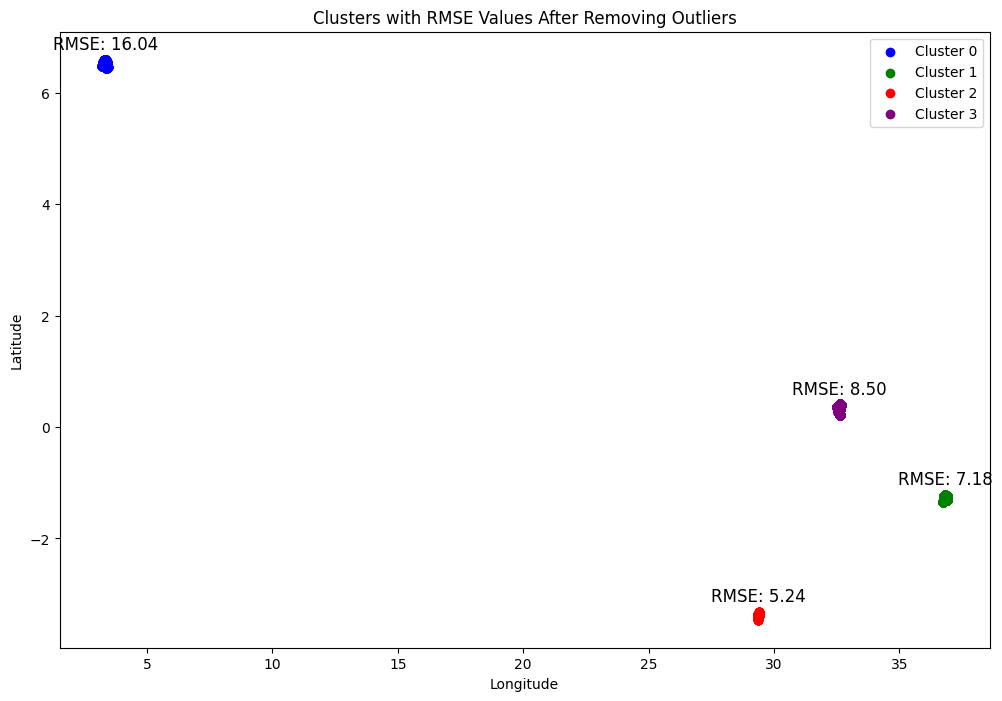

In [3]:
# Convert back to DataFrame
train_data_imputed = pd.DataFrame(train_data_numeric, columns=numeric_columns)

# Add the cluster column back to the imputed DataFrame
train_data_imputed['cluster'] = train_data['cluster'].values

# delete the whole features with more than 65 percent missing values
missing_values = train_data_imputed.isnull().mean()
missing_features = missing_values[missing_values > 0.70].index
train_data_imputed.drop(columns=missing_features, inplace=True)

# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from each cluster
rmse_results = {}

for cluster in clusters:
    cluster_data = train_data_imputed[train_data_imputed['cluster'] == cluster]
    
    # Remove outliers in pm2_5
    cluster_data = remove_outliers(cluster_data, 'pm2_5')
    # Skip clusters with fewer than 5 samples after outlier removal
    if len(cluster_data) < 5:
        print(f'Skipping cluster {cluster} due to insufficient data')
        continue
    
    # Prepare features and target
    features = cluster_data.drop(columns=['pm2_5', 'cluster', 'site_longitude', 'site_latitude'])
    # normalize the features
    features = (features - features.mean()) / features.std()    
    target = cluster_data['pm2_5']
    
    # Initialize model
    model = CatBoostRegressor()
    
    # Perform cross-validation and calculate RMSE
    cv_scores = cross_val_score(model, features, target, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-cv_scores)
    rmse_results[cluster] = rmse.mean()

# Display the RMSE results
for cluster, rmse in rmse_results.items():
    print(f'Cluster {cluster}: RMSE = {rmse:.2f}')

# Plot the clusters
plt.figure(figsize=(12, 8))

# Define colors for each cluster
colors = ['blue', 'green', 'red', 'purple']

# Plot each cluster
for cluster in clusters:
    cluster_data = train_data[train_data['cluster'] == cluster]
    plt.scatter(cluster_data['site_longitude'], cluster_data['site_latitude'], 
                color=colors[int(cluster) % len(colors)], label=f'Cluster {cluster}')

# Annotate the RMSE values
for cluster, rmse in rmse_results.items():
    centroid = site_coordinates[site_coordinates['cluster'] == cluster][['site_longitude', 'site_latitude']].mean()
    plt.annotate(f'RMSE: {rmse:.2f}', (centroid['site_longitude'], centroid['site_latitude']), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='black')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters with RMSE Values After Removing Outliers')
plt.legend()
plt.show()


In [4]:
# Train models for each cluster and store them
models = {}
centroids = {}

for cluster in clusters:
    cluster_data = train_data_imputed[train_data_imputed['cluster'] == cluster]
    
    # Remove outliers in pm2_5
    cluster_data = remove_outliers(cluster_data, 'pm2_5')
    
    # Skip clusters with fewer than 5 samples after outlier removal
    if len(cluster_data) < 5:
        print(f'Skipping cluster {cluster} due to insufficient data')
        continue
    
    # Prepare features and target
    features = cluster_data.drop(columns=['pm2_5', 'cluster', 'site_longitude', 'site_latitude'])
    # Normalize the features
    features = (features - features.mean()) / features.std()
    target = cluster_data['pm2_5']
    
    # Initialize model
    model = CatBoostRegressor()
    model.fit(features, target)
    models[cluster] = model
    
    # Calculate centroid
    centroids[cluster] = cluster_data[['site_latitude', 'site_longitude']].mean().values


Learning rate set to 0.039556
0:	learn: 21.7240210	total: 39.6ms	remaining: 39.6s
1:	learn: 21.3848849	total: 46.6ms	remaining: 23.3s
2:	learn: 21.0745973	total: 51.8ms	remaining: 17.2s
3:	learn: 20.7573912	total: 56.7ms	remaining: 14.1s
4:	learn: 20.4746171	total: 61.6ms	remaining: 12.3s
5:	learn: 20.1883091	total: 66.6ms	remaining: 11s
6:	learn: 19.9000591	total: 71.2ms	remaining: 10.1s
7:	learn: 19.6217545	total: 75.8ms	remaining: 9.4s
8:	learn: 19.3777514	total: 80.2ms	remaining: 8.83s
9:	learn: 19.1144684	total: 83.9ms	remaining: 8.31s
10:	learn: 18.8646263	total: 87.7ms	remaining: 7.88s
11:	learn: 18.6524290	total: 91.5ms	remaining: 7.53s
12:	learn: 18.4442403	total: 95.3ms	remaining: 7.24s
13:	learn: 18.2307436	total: 98.9ms	remaining: 6.96s
14:	learn: 18.0078332	total: 102ms	remaining: 6.7s
15:	learn: 17.8343421	total: 105ms	remaining: 6.47s
16:	learn: 17.6600092	total: 108ms	remaining: 6.24s
17:	learn: 17.5018523	total: 111ms	remaining: 6.03s
18:	learn: 17.3379203	total: 113ms

In [5]:
# print the features 
print(features)

      sulphurdioxide_so2_column_number_density  \
202                                        NaN   
203                                        NaN   
204                                  -0.466872   
205                                   0.777498   
206                                  -0.715315   
...                                        ...   
7070                                       NaN   
7071                                       NaN   
7072                                       NaN   
7073                                       NaN   
7074                                  1.198202   

      sulphurdioxide_so2_column_number_density_amf  \
202                                            NaN   
203                                            NaN   
204                                      -0.948217   
205                                       1.540413   
206                                       1.870097   
...                                            ...   
7070                 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from geopy.distance import great_circle

# Assuming models and cluster_info are already defined as per the training step

# Load the test data
test_data = pd.read_csv('Test.csv')

# Transform the date column to datetime
test_data['date'] = pd.to_datetime(test_data['date'])

# Delete the date and the hour columns
test_data.drop(['date', 'hour'], axis=1, inplace=True)

# Filter out non-numeric columns
numeric_columns = test_data.select_dtypes(include=[np.number]).columns
test_data_numeric = test_data[numeric_columns]

# Convert back to DataFrame
test_data_imputed = pd.DataFrame(test_data_numeric, columns=numeric_columns)
# select the same features as the training data imputed train_data_imputed without the pm2_5

test_data_imputed = test_data_imputed[train_data_imputed.drop(columns=['pm2_5', 'cluster', 'site_longitude', 'site_latitude']).columns]
# Prepare features for the test set
test_features = test_data_imputed.drop(columns=['pm2_5', 'site_longitude','site_latitude'], errors='ignore')  # Drop pm2_5 if it exists

# Normalize the features using the same scaler fitted on the training data
scaler = StandardScaler()
test_features = scaler.fit_transform(test_features)
# drop site longitude and latitude
# Predict on the test set
predictions = []

# Function to find the closest cluster
def find_closest_cluster(lat, lon, clusters):
    closest_distance = float('inf')
    closest_cluster = None
    for _, cluster in clusters.iterrows():
        distance = great_circle((lat, lon), (cluster['site_latitude'], cluster['site_longitude'])).kilometers
        if distance < closest_distance:
            closest_distance = distance
            closest_cluster = cluster['cluster']
    return closest_cluster

for index, test_point in test_data.iterrows():
    test_lat = test_point['site_latitude']
    test_lon = test_point['site_longitude']
    
    cluster_predictions = []
    for _, cluster in cluster_info.iterrows():
        distance = great_circle((test_lat, test_lon), (cluster['site_latitude'], cluster['site_longitude'])).kilometers
        if distance <= cluster['radius'] / 1000:
            model = models[cluster['cluster']]
            
            prediction = model.predict(test_features[index].reshape(1, -1))[0]
            cluster_predictions.append(prediction)
    
    if len(cluster_predictions) > 0:
        final_prediction = np.mean(cluster_predictions)
    else:
        closest_cluster = find_closest_cluster(test_lat, test_lon, cluster_info)
        model = models[closest_cluster]
        final_prediction = model.predict(test_features[index].reshape(1, -1))[0]
    
    predictions.append(final_prediction)



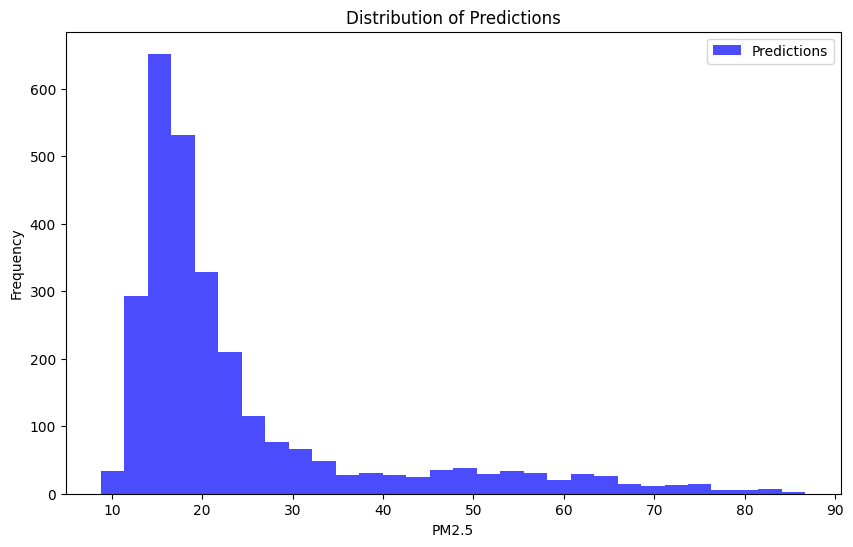

In [7]:
# Create a DataFrame for the predictions
# minus 10 to the predictions
predicted_pm2_5 = pd.DataFrame({
    'id': test_data['id'],
    'pm2_5': predictions 
})

# Save the predictions to a CSV file
predicted_pm2_5.to_csv('SampleSubmission.csv', index=False)

# Plot the distribution of predictions
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=30, alpha=0.7, label='Predictions', color='b')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions')
plt.legend()
plt.show()


Ceci fonctionne mieux et donne un score de 13 quelque chose

In [1]:
# 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
import joblib

# seed 12 
np.random.seed(1000)

# Load the training data
train_data = pd.read_csv('Train.csv')

# drop outliers
train_data = train_data[train_data['pm2_5'] < 200]
# Transform the date column to datetime
train_data['date'] = pd.to_datetime(train_data['date'])

# Extract the month, week, and year from the date column
train_data['week'] = train_data['date'].dt.isocalendar().week
train_data['year'] = train_data['date'].dt.year

# transform longitude and latitude 
train_data['site_latitude'] = np.radians(train_data['site_latitude'])
train_data['site_longitude'] = np.radians(train_data['site_longitude'])

# Drop the date and the hour columns
train_data.drop(['date', 'hour'], axis=1, inplace=True)

# Filter out non-numeric columns
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
train_data_numeric = train_data[numeric_columns]

# drop the pm2_5 column
train_data_numeric = train_data_numeric.drop(columns=['pm2_5'])

# Normalize the features for feature selection
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_data_numeric)

# Initialize models for feature selection
lgb_model = lgb.LGBMRegressor()
xgb_model = XGBRegressor()
rf_model = RandomForestRegressor()

# Fit models
lgb_model.fit(scaled_features, train_data['pm2_5'])
xgb_model.fit(scaled_features, train_data['pm2_5'])
rf_model.fit(scaled_features, train_data['pm2_5'])

# Select features
lgb_selector = SelectFromModel(lgb_model, prefit=True, max_features=35)
xgb_selector = SelectFromModel(xgb_model, prefit=True, max_features=35)
rf_selector = SelectFromModel(rf_model, prefit=True, max_features=35)

# Get selected features
lgb_features = set(train_data_numeric.columns[lgb_selector.get_support()])
xgb_features = set(train_data_numeric.columns[xgb_selector.get_support()])
rf_features = set(train_data_numeric.columns[rf_selector.get_support()])

# Combine the features from all models
selected_features = list(lgb_features | xgb_features | rf_features)

print(f"Selected features ({len(selected_features)}): {selected_features}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17101
[LightGBM] [Info] Number of data points in the train set: 8038, number of used features: 75
[LightGBM] [Info] Start training from score 23.518117
Selected features (36): ['cloud_sensor_zenith_angle', 'cloud_solar_zenith_angle', 'formaldehyde_cloud_fraction', 'site_longitude', 'uvaerosolindex_sensor_altitude', 'nitrogendioxide_stratospheric_no2_column_number_density', 'year', 'week', 'cloud_cloud_top_pressure', 'carbonmonoxide_co_column_number_density', 'ozone_solar_azimuth_angle', 'site_latitude', 'ozone_cloud_fraction', 'uvaerosolindex_sensor_azimuth_angle', 'ozone_o3_effective_temperature', 'cloud_cloud_base_height', 'ozone_o3_column_number_density', 'uvaerosolindex_absorbing_aerosol_index', 'uvaerosolindex_solar_zenith_angle', 'nitrogendioxide_sensor_azimuth_angle', 'ozone_solar_zenith_ang

In [2]:
# import PCA
from sklearn.decomposition import PCA
# catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold

# only use the selected features
train_data = train_data[selected_features + ['pm2_5']]
# Transform the date column to datetime
# Drop the date and the hour columns
#train_data.drop(['date', 'hour'], axis=1, inplace=True)

# Filter out non-numeric columns
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
train_data_numeric = train_data[numeric_columns]

# Delete features with more than 65% missing values
missing_values = train_data_numeric.isnull().mean()
missing_features = missing_values[missing_values > 0.65].index
train_data_numeric.drop(columns=missing_features, inplace=True)

# XGBoost for imputation
def xgboost_imputer(df):
    for column in df.columns:
        if df[column].isnull().any():
            model = XGBRegressor()
            train = df[df[column].notnull()]
            test = df[df[column].isnull()]
            model.fit(train.drop(columns=[column]), train[column])
            df.loc[df[column].isnull(), column] = model.predict(test.drop(columns=[column]))
    return df

# Handle missing values with XGBoost
train_data_imputed = xgboost_imputer(train_data_numeric)

# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.15)
    Q3 = df[column].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from pm2_5
train_data_imputed = remove_outliers(train_data_imputed, 'pm2_5')

# Prepare features and target
features = train_data_imputed.drop(columns=['pm2_5'])
target = train_data_imputed['pm2_5']

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=33)  # Reduce dimensionality
features_pca = pca.fit_transform(features_scaled)

# Prepare K-Fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=0)
models = [CatBoostRegressor(random_state=1000, verbose=1), lgb.LGBMRegressor(random_state=1000), XGBRegressor(random_state=1000)]

# Train models and predict
predictions = []
for train_index, test_index in kf.split(features_pca):
    X_train, X_test = features_pca[train_index], features_pca[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    fold_predictions = np.zeros((X_test.shape[0], len(models)))
    
    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        fold_predictions[:, i] = model.predict(X_test)
    
    # Average predictions from all models for each fold
    predictions.append(np.mean(fold_predictions, axis=1))

# Concatenate all fold predictions
final_predictions = np.concatenate(predictions)

# Post-process predictions (optional)
final_predictions *= 1  # Placeholder for any post-processing multiplier

Learning rate set to 0.056695
0:	learn: 13.4183443	total: 160ms	remaining: 2m 40s
1:	learn: 13.2175670	total: 167ms	remaining: 1m 23s
2:	learn: 13.0469624	total: 174ms	remaining: 57.9s
3:	learn: 12.8764429	total: 182ms	remaining: 45.3s
4:	learn: 12.7138699	total: 204ms	remaining: 40.7s
5:	learn: 12.5612963	total: 209ms	remaining: 34.7s
6:	learn: 12.4323799	total: 213ms	remaining: 30.2s
7:	learn: 12.2983781	total: 217ms	remaining: 26.9s
8:	learn: 12.1716486	total: 220ms	remaining: 24.2s
9:	learn: 12.0476900	total: 224ms	remaining: 22.1s
10:	learn: 11.9441780	total: 227ms	remaining: 20.4s
11:	learn: 11.8406271	total: 229ms	remaining: 18.9s
12:	learn: 11.7535191	total: 232ms	remaining: 17.6s
13:	learn: 11.6799235	total: 234ms	remaining: 16.5s
14:	learn: 11.6007457	total: 236ms	remaining: 15.5s
15:	learn: 11.5518700	total: 239ms	remaining: 14.7s
16:	learn: 11.4756522	total: 242ms	remaining: 14s
17:	learn: 11.3948271	total: 245ms	remaining: 13.3s
18:	learn: 11.3177486	total: 248ms	remaining

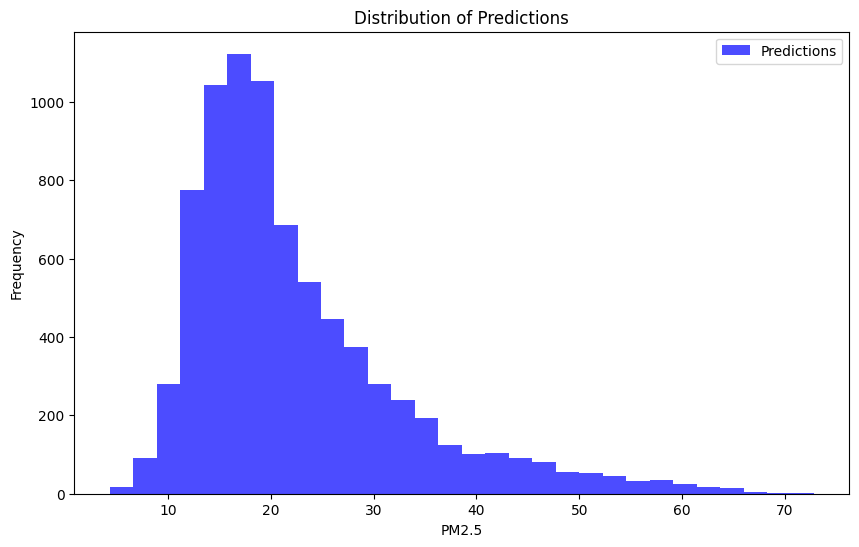

['pca.joblib']

In [3]:
import matplotlib.pyplot as plt
# Plot predictions
plt.figure(figsize=(10, 6))
plt.hist(final_predictions, bins=30, alpha=0.7, label='Predictions', color='b')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions')
plt.legend()
plt.show()

# Save models and scaler
joblib.dump(models, 'ensemble_models.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(pca, 'pca.joblib')



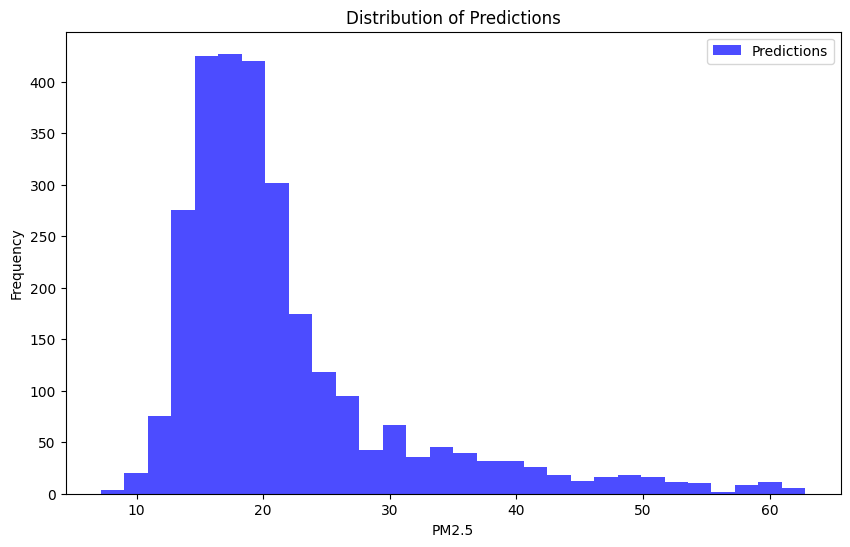

In [4]:
# Load the test data
test_data = pd.read_csv('Test.csv')

# Transform the date column to datetime and extract features
test_data['date'] = pd.to_datetime(test_data['date'])
test_data['week'] = test_data['date'].dt.isocalendar().week
test_data['year'] = test_data['date'].dt.year

# Transform longitude and latitude
test_data['site_latitude'] = np.radians(test_data['site_latitude'])
test_data['site_longitude'] = np.radians(test_data['site_longitude'])

# Filter out non-numeric columns
test_data_numeric = test_data[selected_features]

# Handle missing values with XGBoost
def xgboost_imputer(df):
    for column in df.columns:
        if df[column].isnull().any():
            model = XGBRegressor()
            train = df[df[column].notnull()]
            test = df[df[column].isnull()]
            model.fit(train.drop(columns=[column]), train[column])
            df.loc[df[column].isnull(), column] = model.predict(test.drop(columns=[column]))
    return df

test_data_imputed = xgboost_imputer(test_data_numeric)

# Scale and transform the test features
scaled_test_features = scaler.transform(test_data_imputed)
pca = joblib.load('pca.joblib')

pca_test_features = pca.transform(scaled_test_features)

# Load the ensemble of trained models
ensemble_models = joblib.load('ensemble_models.joblib')

# Predict on the test set with each model and average the results
ensemble_predictions = np.column_stack([model.predict(pca_test_features) for model in ensemble_models]).mean(axis=1)
# aslo apply median
ensemble_predictions_median = np.column_stack([model.predict(pca_test_features) for model in ensemble_models]).median(axis=1)
# Apply post-processing multiplier (optional)
multiplier = 1  # Placeholder for any scaling based on domain knowledge
ensemble_predictions *= multiplier

# Create a DataFrame for the predictions
predicted_pm2_5 = pd.DataFrame({
    'id': test_data['id'],
    'pm2_5': ensemble_predictions
})

# Save the predictions to a CSV file
predicted_pm2_5.to_csv('SampleSubmission.csv', index=False)

# Plot the distribution of predictions
plt.figure(figsize=(10, 6))
plt.hist(ensemble_predictions, bins=30, alpha=0.7, label='Predictions', color='b')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions')
plt.legend()
plt.show()

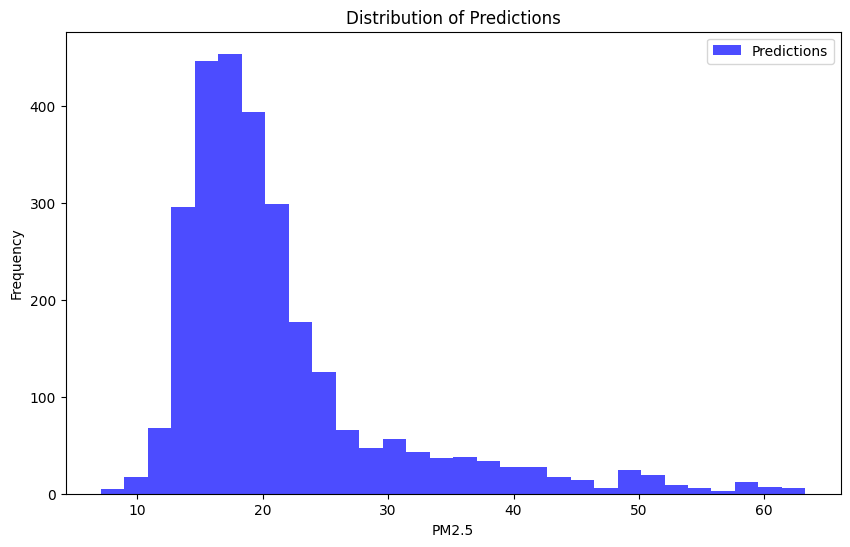

In [7]:
# Stack the predictions from the ensemble models
ensemble_predictions = np.column_stack([model.predict(pca_test_features) for model in ensemble_models])

# Calculate the median of the stacked predictions along axis 1
median_predictions = np.median(ensemble_predictions, axis=1)

# Apply post-processing multiplier (optional)
multiplier = 1  # Placeholder for any scaling based on domain knowledge
median_predictions *= multiplier

# Create a DataFrame for the predictions
predicted_pm2_5 = pd.DataFrame({
    'id': test_data['id'],
    'pm2_5': median_predictions
})

# Save the predictions to a CSV file
predicted_pm2_5.to_csv('SampleSubmission_median.csv', index=False)

# Plot the distribution of predictions
plt.figure(figsize=(10, 6))
plt.hist(median_predictions, bins=30, alpha=0.7, label='Predictions', color='b')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions')
plt.legend()
plt.show()

In [5]:
# print the number of features in the test data and the train data
print(f"Number of features in the training data: {train_data_imputed.shape[1]}")
print(f"Number of features in the test data: {test_data.shape[1]}")

Number of features in the training data: 37
Number of features in the test data: 81
